### Import Library

In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt     
import scipy

In [6]:
data_root = './dataset image-processing/dataset_ktp_selfie'

### Data generator for training and validation

In [7]:
img_height = 150
img_width = 150
IMAGE_SHAPE = (img_width, img_height)

batch_size = 64

TRAINING_DATA_DIR = str(data_root)

datagen_kwargs = dict(rescale=1./255, validation_split=.30)
train_datagen = ImageDataGenerator(
    **datagen_kwargs,
    rotation_range=30, 
    width_shift_range=0.2,
    height_shift_range=0.2, 
    brightness_range=[0.5,1.5],  
    zoom_range=0.2,
    horizontal_flip=True, 
    preprocessing_function=None, 
    data_format=None, 
    #validation_split=0.2, 
    dtype=None
) # set validation split

valid_datagen = ImageDataGenerator(**datagen_kwargs)



train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
) # set as training data

valid_generator = valid_datagen.flow_from_directory(
    #train_data_dir, # same directory as training data
    TRAINING_DATA_DIR,
    target_size=(img_height, img_width),
    batch_size= batch_size,
    class_mode='categorical',
    shuffle = True,
    subset='validation'
) # set as validation data

Found 1402 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


## Create TF Model

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape = (img_width, img_height, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    # tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2), 
    # tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    # tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(32, activation='relu'), 
    tf.keras.layers.Dense(2, activation='sigmoid')  
])

# Compile model
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [10]:
mc = tf.keras.callbacks.ModelCheckpoint('ktp_selfie_model_01.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
history = model.fit(
            train_generator,
            epochs=30,
            validation_data=valid_generator,
            callbacks = [mc], 
            )

Epoch 1/30
22/22 [==============================] - ETA: 0s - loss: 0.9154 - accuracy: 0.6134
Epoch 1: val_loss improved from inf to 0.58340, saving model to ktp_selfie_model_01.h5
22/22 [==============================] - 18s 483ms/step - loss: 0.9154 - accuracy: 0.6134 - val_loss: 0.5834 - val_accuracy: 0.7067
Epoch 2/30
22/22 [==============================] - ETA: 0s - loss: 0.4454 - accuracy: 0.8153
Epoch 2: val_loss improved from 0.58340 to 0.52224, saving model to ktp_selfie_model_01.h5
22/22 [==============================] - 11s 478ms/step - loss: 0.4454 - accuracy: 0.8153 - val_loss: 0.5222 - val_accuracy: 0.7833
Epoch 3/30
22/22 [==============================] - ETA: 0s - loss: 0.3685 - accuracy: 0.8459
Epoch 3: val_loss did not improve from 0.52224
22/22 [==============================] - 10s 459ms/step - loss: 0.3685 - accuracy: 0.8459 - val_loss: 0.9212 - val_accuracy: 0.6367
Epoch 4/30
22/22 [==============================] - ETA: 0s - loss: 0.3127 - accuracy: 0.8802
Epo

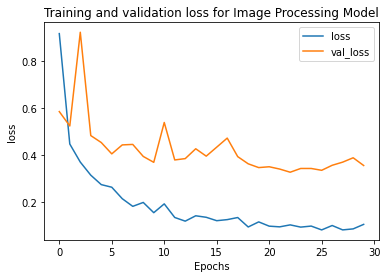

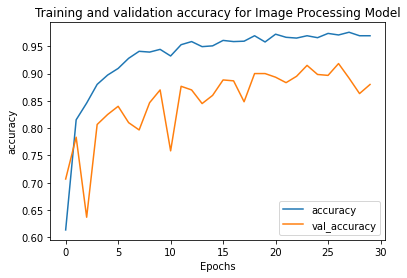

In [12]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.title(f'Training and validation {metric} for Image Processing Model')
    plt.show()
    
plot_graphs(history, "loss")
plot_graphs(history, "accuracy")

In [18]:
import tensorflow as tf
final_model = tf.keras.models.load_model('./ktp_selfie_model_01.h5')

### Plot Model

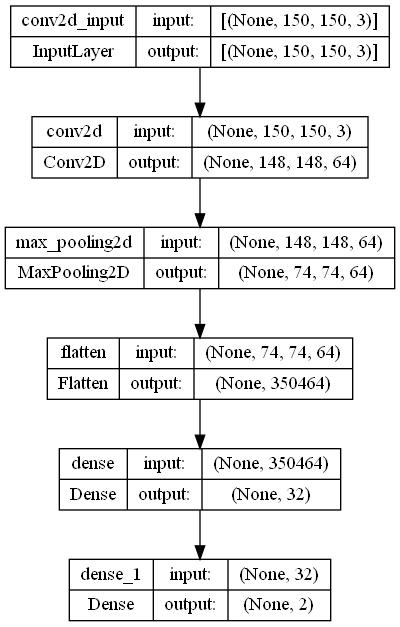

In [20]:
tf.keras.utils.plot_model(final_model, show_shapes=True)

### Confusion Matrix and Classification Report

In [21]:
valid_generator = valid_datagen.flow_from_directory(
    #train_data_dir, # same directory as training data
    TRAINING_DATA_DIR,
    target_size=(img_height, img_width),
    batch_size= batch_size,
    class_mode='categorical',
    shuffle = False,
    subset='validation'
) # set as validation data

Found 600 images belonging to 2 classes.


In [37]:
predict = final_model.predict(valid_generator)
predictions = []
for i in range(len(predict)):
    predictions.append(np.argmax(predict[i]))

cm = confusion_matrix(valid_generator.classes, predictions)

print(cm)
print(classification_report(valid_generator.classes, predictions))


10/10 [==============================] - 1s 141ms/step
[[265  35]
 [ 28 272]]
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       300
           1       0.89      0.91      0.90       300

    accuracy                           0.90       600
   macro avg       0.90      0.90      0.89       600
weighted avg       0.90      0.90      0.89       600



10/10 [==============================] - 2s 155ms/step


[Text(0, 0.5, 'KTP'), Text(0, 1.5, 'Selfie')]

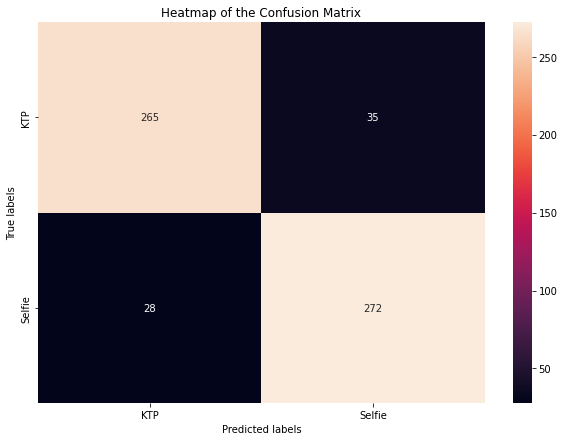

In [34]:
target_names = ['KTP','Selfie']

fig,ax=plt.subplots(1,1,
                    figsize=(10,7)
                   )

sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Heatmap of the Confusion Matrix'); 
ax.xaxis.set_ticklabels(target_names); ax.yaxis.set_ticklabels(target_names)